In [10]:
!pip install python_speech_features

In [31]:
import pandas as pd
import numpy as np
import textgrids
import librosa
import os 
import glob
from  python_speech_features.base import mfcc, logfbank
from python_speech_features.sigproc import framesig
from tqdm import tqdm 
from sklearn import model_selection, preprocessing, metrics 
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf

In [12]:
audio_path = 'Data/Audio/'
audio_extension = '.wav'
annotation_path = 'Data/Annotation/'
annotation_extension = '.TextGrid'
n_frames = 32
audio_files = []
for foldername, subfolders, filenames in os.walk(audio_path):
    for filename in filenames:
        if filename.endswith(audio_extension):
            file_path = os.path.join(foldername, filename)
            audio_files.append(file_path)
audio_files = sorted(audio_files)

annotated_files = []

for foldername, subfolders, filenames in os.walk(annotation_path):
    for filename in filenames:
        if filename.endswith(annotation_extension):
            file_path = os.path.join(foldername, filename)
            annotated_files.append(file_path)
annotated_files = sorted(annotated_files)

print(annotated_files)


['Data/Annotation/Female/PTDB-TUG/mic_F01_sa2.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si454.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si473.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si502.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si523.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si528.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si575.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si606.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si629.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_si640.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_sx16.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F01_sx42.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F02_sa1.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F02_si654.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F02_si675.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F02_si698.TextGrid', 'Data/Annotation/Female/PTDB-TUG/mic_F02_si737.TextGrid', 'Data/Annotation/Fe

In [14]:
# Extracting features from audio files
train_features = []
for i in tqdm(range(len(audio_files))):
    audio_signal, sample_rate = librosa.load(audio_files[i])
    labels = []
    grid = textgrids.TextGrid(annotated_files[i])
    for intervals in grid['silences']:
        label = int(intervals.text)
        duration = intervals.dur
        duration_samples = int(duration * sample_rate)
        for samples in range(duration_samples):
            labels.append(label)
    features_logfbank = logfbank(signal=audio_signal, samplerate=sample_rate, winlen=0.025, winstep=0.01, nfilt=32, nfft=1024, lowfreq=0, highfreq=None, preemph=0.97)
    labels_ = framesig(sig = labels, frame_len=0.025*sample_rate, sample_rate = 0.01*sample_rate, winfunc=np.hamming)
    labels__ = np.array([0 for i in range(labels_.shape[0])])
    
    for j in range(labels_.shape[0]):
        if np.sum(labels_[j], axis = 0) > labels_.shape[0]/2:
            labels__[j] = 1
        else:
            labels__[j] = 0
    
    spectrogram = np.zeros((n_frames, n_frames))
    for j in range(int(features_logfbank.shape[0]/n_frames)):
        spectrogram = features_logfbank[j*n_frames:(j+1)*n_frames]
        if np.sum(labels__[j*n_frames:(j+1)*n_frames]) > n_frames/2:
            label = 1
        else:
            label = 0
        train_features.append((label, spectrogram))
        
    

100%|██████████| 719/719 [00:27<00:00, 26.21it/s]


In [15]:
train_features[0][1].shape

(32, 32)

In [16]:
x_data = np.zeros(len(train_features), dtype=object)
y_data = np.zeros(len(train_features), dtype=object)

for i in range(len(train_features)):
    x_data[i] = train_features[i][1]
    y_data[i] = train_features[i][0]
    
x_data = np.array(x_data.tolist())
y_data = np.array(y_data.tolist())

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.33, random_state=42)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

scale = preprocessing.MinMaxScaler()
x_train = scale.fit_transform(x_train)
x_train = x_train.reshape(x_train.shape[0], n_frames, n_frames)
x_test = scale.transform(x_test)
x_test = x_test.reshape(x_test.shape[0], n_frames, n_frames)


(6342, 32, 32) (6342,) (3125, 32, 32) (3125,)


In [17]:
l1 = []
for i in range(len(y_train)):
    if y_train[i] == 0:
        l1.append([True,False])
    else:
        l1.append([False,True])
y_train = np.array(l1)
l1 = []
for i in range(len(y_test)):
    if y_test[i] == 0:
        l1.append([True,False])
    else:
        l1.append([False,True])
y_test = np.array(l1)

In [18]:
stride = int(n_frames/2) - 1

x_train_reshaped = x_train[:int(np.floor(x_train.shape[0]/stride)*stride)]
x_train_reshaped = x_train_reshaped.reshape(int(x_train_reshaped.shape[0]/stride),stride,  n_frames, n_frames, 1)
y_train_resahped = y_train[:(int(np.floor(y_train.shape[0]/stride))*stride)]
y_train_resahped = y_train_resahped.reshape(int(y_train_resahped.shape[0]/stride),stride, 2)
x_test_reshaped = x_test[:(int(np.floor(x_test.shape[0]/stride))*stride)]
x_test_reshaped = x_test_reshaped.reshape(int(x_test_reshaped.shape[0]/stride),stride,  n_frames, n_frames, 1)
y_test_reshaped = y_test[:(int(np.floor(y_test.shape[0]/stride))*stride)]
y_test_reshaped = y_test_reshaped.reshape(int(y_test_reshaped.shape[0]/stride),stride, 2)

print(x_train_reshaped.shape, y_train_resahped.shape, x_test_reshaped.shape, y_test_reshaped.shape)



(422, 15, 32, 32, 1) (422, 15, 2) (208, 15, 32, 32, 1) (208, 15, 2)


In [19]:
def f1_score(y_true, y_pred):
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    predicted_positives = K.sum(K.clip(y_pred, 0, 1))
    possible_positives = K.sum(K.clip(y_true, 0, 1))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1


In [1]:
model = models.Sequential()
model.add(layers.TimeDistributed(layers.Conv2D(64, (5, 5), activation='elu'), input_shape=(stride, n_frames, n_frames, 1)))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.TimeDistributed(layers.Dense(64, activation='elu')))
model.add(layers.Dropout(0.25))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
model.add(layers.Dropout(0.25))
model.add(layers.TimeDistributed(layers.Dense(y_train[-1].shape[0], activation='softmax')))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score, 'accuracy', Recall(), Precision()])

NameError: name 'models' is not defined

In [34]:
epochs = 25
batch_size = 32
callbacks = None

history = model.fit(
    x_train_reshaped, y_train_resahped,
    validation_data=(x_test_reshaped, y_test_reshaped),
    epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/25
14/14 [==============================] - 13s 640ms/step - loss: 0.6520 - f1_score: 0.6614 - accuracy: 0.6618 - recall: 0.6618 - precision: 0.6618 - val_loss: 0.6191 - val_f1_score: 0.6893 - val_accuracy: 0.6869 - val_recall: 0.6869 - val_precision: 0.6869
Epoch 2/25
14/14 [==============================] - 9s 612ms/step - loss: 0.6212 - f1_score: 0.6756 - accuracy: 0.6776 - recall: 0.6776 - precision: 0.6776 - val_loss: 0.5875 - val_f1_score: 0.6893 - val_accuracy: 0.6869 - val_recall: 0.6869 - val_precision: 0.6869
Epoch 3/25
14/14 [==============================] - 8s 604ms/step - loss: 0.5868 - f1_score: 0.6708 - accuracy: 0.6758 - recall: 0.6758 - precision: 0.6758 - val_loss: 0.5119 - val_f1_score: 0.7051 - val_accuracy: 0.7051 - val_recall: 0.7051 - val_precision: 0.7051
Epoch 4/25
14/14 [==============================] - 9s 615ms/step - loss: 0.5205 - f1_score: 0.6724 - accuracy: 0.6776 - recall: 0.6776 - precision: 0.6776 - val_loss: 0.4704 - val_f1_score: 0.6970 - v

/var/folders/v5/xpg09y4s5k92w547khpc4rxm0000gn/T/ipykernel_50090/1750136812.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 1)


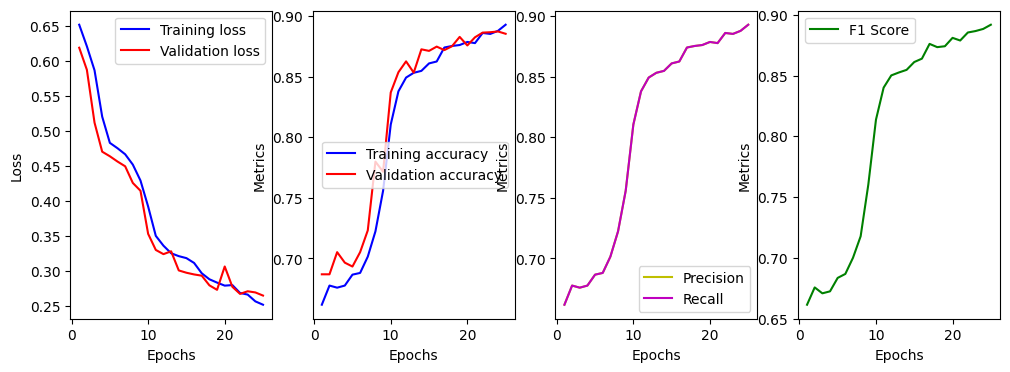

In [39]:
from matplotlib import pyplot as plt
# Get loss and metrics history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
f1 = history.history['f1_score']
precision = history.history['precision']
recall = history.history['recall']

# Plot the loss and metrics across epochs
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))
plt.title('Training and Validation Loss')
plt.subplot(1, 4, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(epochs, precision, 'y', label='Precision')
plt.plot(epochs, recall, 'm', label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(epochs, f1, 'g', label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.show()


In [ ]:
model.save('model.h5')